## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from neural_networks.seg_reg_net import SegRegNet
from neural_networks.keras_utils import EvalMetricsCallback
from utils.data.data_augmentation import augment16_from_dir_and_save
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_logs, plot_seg_reg_maps

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

#### Create validation split from the initial training data

In [4]:
move_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)
create_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)

#### Data augmentation (train/val split)

In [5]:
augment16_from_dir_and_save(in_path=config.TRAIN_PATH,
                            save_path=config.TRAIN_PATH,
                            rseed=config.RAND_SEED)

augment16_from_dir_and_save(in_path=config.VAL_PATH,
                            save_path=config.VAL_PATH,
                            rseed=config.RAND_SEED + 1)

#### Data generators

In [6]:
train_params = {
    'dim': config.PATCH_DIM,
    'batch_size': config.BATCH_SIZE,
    'patches_per_image': config.PATCHES_PER_IMAGE,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': config.SHUFFLE,
    'ignored_images': config.IGNORED_IMAGES,
    'data_augmentation': True,
    'output_mode': 'seg_reg',
    'gt_seg_thr': config.GT_SEG_THR
}

val_params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False,
    'data_augmentation': True,
    'output_mode': 'seg_reg',
    'gt_seg_thr': config.GT_SEG_THR
}

In [7]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **train_params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **val_params)

## 3. Instantiate a SegRegNet

In [8]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE)

## 4. Train the model

In [9]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

### Seg training

In [10]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.SEG_EPOCHS,
                                    callbacks=[model_checkpoint],
                                    verbose=1)

Epoch 1/10
256/256 [==============================] - 77s 300ms/step - loss: 0.1878 - activation_1_loss: 0.1878 - conv2d_12_loss: 0.0423 - val_loss: 0.0862 - val_activation_1_loss: 0.0862 - val_conv2d_12_loss: 0.0409
Epoch 2/10
256/256 [==============================] - 87s 340ms/step - loss: 0.0991 - activation_1_loss: 0.0991 - conv2d_12_loss: 0.0411 - val_loss: 0.0825 - val_activation_1_loss: 0.0825 - val_conv2d_12_loss: 0.0425
Epoch 3/10
256/256 [==============================] - 87s 339ms/step - loss: 0.0911 - activation_1_loss: 0.0911 - conv2d_12_loss: 0.0417 - val_loss: 0.0861 - val_activation_1_loss: 0.0861 - val_conv2d_12_loss: 0.0430
Epoch 4/10
256/256 [==============================] - 86s 338ms/step - loss: 0.0875 - activation_1_loss: 0.0875 - conv2d_12_loss: 0.0429 - val_loss: 0.0818 - val_activation_1_loss: 0.0818 - val_conv2d_12_loss: 0.0440
Epoch 5/10
256/256 [==============================] - 88s 344ms/step - loss: 0.0863 - activation_1_loss: 0.0863 - conv2d_12_loss: 0.

#### Save and load train stats/logs/history

In [11]:
def save_logs(model):
    logs = model.history.history.copy()

    logs['train_loss'] = logs.pop('loss')
    logs['train_size'] = train_generator.get_size()
    logs['val_size'] = val_generator.get_size()
    logs['rand_seed'] = config.RAND_SEED
    logs['shuffle'] = config.SHUFFLE
    logs['seg_loss_name'] = config.SEG_LOSS_NAME
    logs['reg_loss_name'] = config.REG_LOSS_NAME
    logs['img_dim'] = config.IMG_DIM
    logs['patch_dim'] = config.PATCH_DIM
    logs['patches_per_image'] = config.PATCHES_PER_IMAGE
    logs['density_map_sigma'] = config.GT_SIGMA
    logs['density_map_multiplication_factor'] = config.DENSITY_MAP_MULTIPLICATION_FACTOR
    logs['sub_experiment_name'] = config.SUB_EXPERIMENT_NAME
    logs['architecture'] = config.ARCHITECTURE_NAME
    
    return logs

min val_loss: 0.0728, epoch: 8


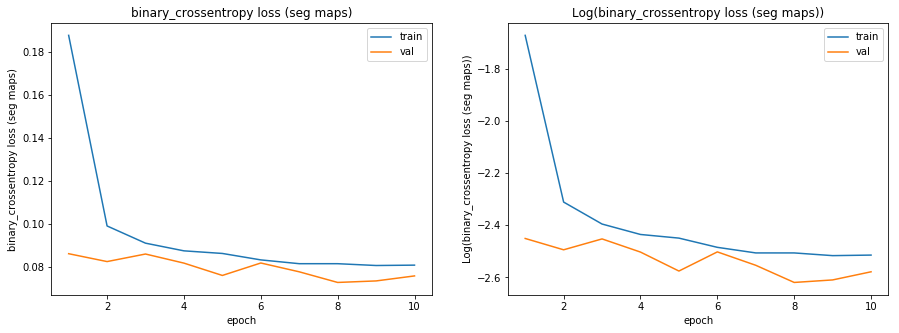

In [12]:
seg_logs = save_logs(model)
write_json(seg_logs, config.SEG_LOGS_FILENAME)
seg_logs = read_json(config.SEG_LOGS_FILENAME)

print(f'min val_loss: {np.min(seg_logs["val_loss"]):.4f}, epoch: {1 + np.argmin(seg_logs["val_loss"])}')

plot_logs(seg_logs['train_loss'], seg_logs['val_loss'], f'{config.SEG_LOSS_NAME} loss (seg maps)')

#### Load the best model

In [13]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE,
                  pretrained_weights=config.CHECKPOINT_FILENAME)

#### Look at one example from the validation set

In [14]:
img, (gt_seg_map, gt_density_map) = val_generator.__getitem__(1)
pred_seg_map, pred_density_map = model.predict(img)

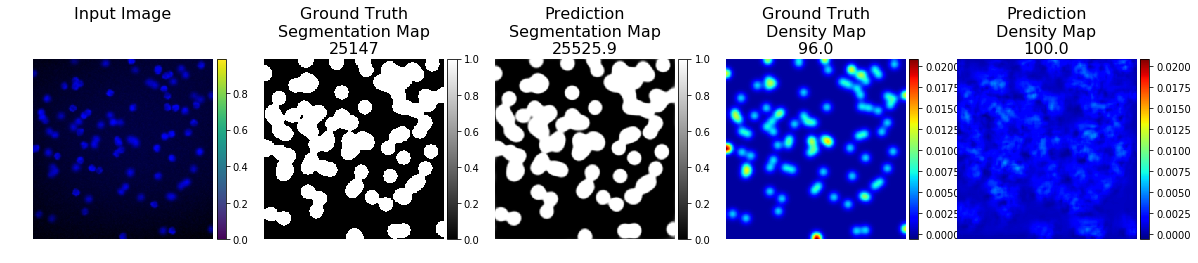

In [15]:
plot_seg_reg_maps(img.squeeze(), gt_seg_map, pred_seg_map, gt_density_map, pred_density_map,
                  config.DENSITY_MAP_MULTIPLICATION_FACTOR)

#### Set trainable=False for all layers of encoder

In [16]:
for idx in range(8):
    model.layers[idx].trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2ccd60aa58> False
<keras.layers.convolutional.Conv2D object at 0x7f2ccd60ab70> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2cbc7ce518> False
<keras.layers.convolutional.Conv2D object at 0x7f2cbc7ce470> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2cbf723438> False
<keras.layers.convolutional.Conv2D object at 0x7f2cbf723080> False
<keras.layers.pooling.MaxPooling2D object at 0x7f2cbf708080> False
<keras.layers.convolutional.Conv2D object at 0x7f2cbf7087b8> False
<keras.layers.convolutional.UpSampling2D object at 0x7f2cbf6856a0> True
<keras.layers.convolutional.Conv2D object at 0x7f2cbf685cf8> True
<keras.layers.convolutional.UpSampling2D object at 0x7f2cbf5ca940> True
<keras.layers.convolutional.UpSampling2D object at 0x7f2cbf6bdc88> True
<keras.layers.convolutional.Conv2D object at 0x7f2cbf5e2cf8> True
<keras.layers.convolutional.Conv2D object at 0x7f2cbf6bd898> True
<keras.layers.convolutional.UpSampling2D object 

### Reg training

#### Prepare the model for the training

In [17]:
model.compile(optimizer=Adam(lr=config.LEARNING_RATE),
              loss=[config.SEG_LOSS_NAME, config.REG_LOSS_NAME],
              loss_weights=[0, 1])

#### Training time

In [18]:
%%time
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.REG_EPOCHS,
                                    callbacks=[model_checkpoint],
                                    verbose=1)

Epoch 1/25
256/256 [==============================] - 92s 358ms/step - loss: 0.0079 - activation_2_loss: 0.0796 - conv2d_24_loss: 0.0079 - val_loss: 0.0059 - val_activation_2_loss: 0.0728 - val_conv2d_24_loss: 0.0059
Epoch 2/25
256/256 [==============================] - 77s 300ms/step - loss: 0.0053 - activation_2_loss: 0.0797 - conv2d_24_loss: 0.0053 - val_loss: 0.0057 - val_activation_2_loss: 0.0728 - val_conv2d_24_loss: 0.0057
Epoch 3/25
256/256 [==============================] - 76s 296ms/step - loss: 0.0051 - activation_2_loss: 0.0795 - conv2d_24_loss: 0.0051 - val_loss: 0.0053 - val_activation_2_loss: 0.0728 - val_conv2d_24_loss: 0.0053
Epoch 4/25
256/256 [==============================] - 82s 320ms/step - loss: 0.0046 - activation_2_loss: 0.0793 - conv2d_24_loss: 0.0046 - val_loss: 0.0052 - val_activation_2_loss: 0.0728 - val_conv2d_24_loss: 0.0052
Epoch 5/25
256/256 [==============================] - 79s 309ms/step - loss: 0.0046 - activation_2_loss: 0.0794 - conv2d_24_loss: 0.

min val_loss: 0.0048, epoch: 20


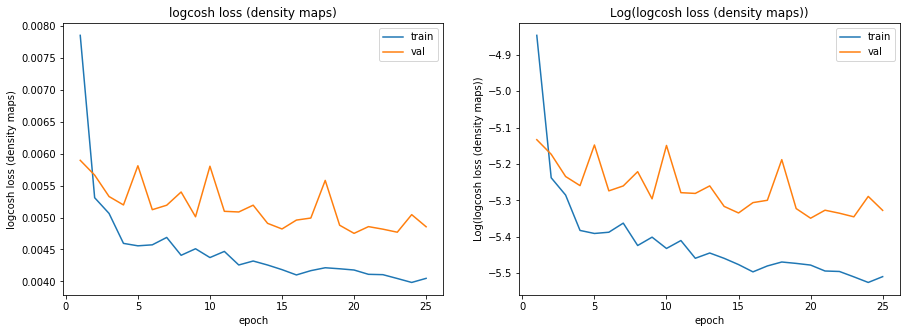

In [19]:
reg_logs = save_logs(model)
write_json(reg_logs, config.REG_LOGS_FILENAME)
reg_logs = read_json(config.REG_LOGS_FILENAME)

print(f'min val_loss: {np.min(reg_logs["val_loss"]):.4f}, epoch: {1 + np.argmin(reg_logs["val_loss"])}')

plot_logs(reg_logs['train_loss'], reg_logs['val_loss'], f'{config.REG_LOSS_NAME} loss (density maps)')

#### Load the best model

In [20]:
model = SegRegNet(seg_loss_name=config.SEG_LOSS_NAME,
                  reg_loss_name=config.REG_LOSS_NAME,
                  loss_weights=[1, 0],
                  learning_rate=config.LEARNING_RATE,
                  pretrained_weights=config.CHECKPOINT_FILENAME)

#### Look at one example from the validation set

In [21]:
img, (gt_seg_map, gt_density_map) = val_generator.__getitem__(1)
pred_seg_map, pred_density_map = model.predict(img)

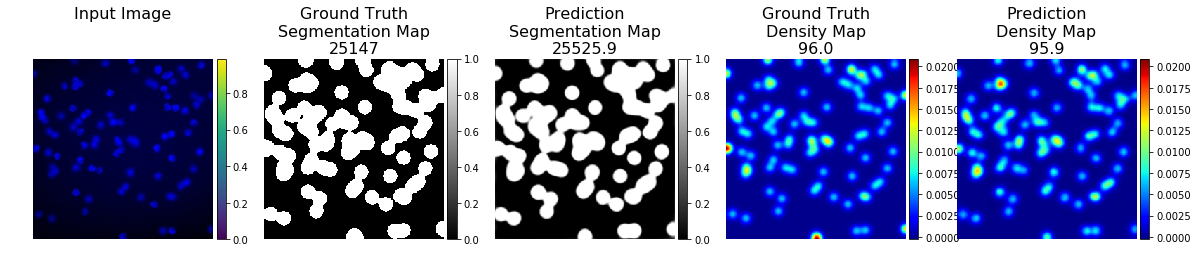

In [22]:
plot_seg_reg_maps(img.squeeze(), gt_seg_map, pred_seg_map, gt_density_map, pred_density_map,
                  config.DENSITY_MAP_MULTIPLICATION_FACTOR)